In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
from config import ModelConfig
from model import get_model, DataGenerator
from simple_loader import get_data
import numpy as np

C:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 0. Model Settings

In [4]:
np.random.seed(ModelConfig.seed)
n_days, n_features = 32, 20
input_shape = (n_days, n_features)

In [5]:
model = get_model(input_shape=input_shape)
model.compile(
    optimizer=ModelConfig.optimizer,
    loss=ModelConfig.loss,
    metrics=ModelConfig.metrics
)

model not found.


In [6]:
model.summary()

Model: "finance"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 finance_data (InputLayer)      [(None, 32, 20)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 32, 256)      15616       ['finance_data[0][0]']           
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 256)     1024        ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 256)      0           ['batch_normalization[0][0]

                                                                                                  
 cnn_res__block_4 (Add)         (None, 32, 256)      0           ['leaky_re_lu_9[0][0]',          
                                                                  'cnn_res__block_3[0][0]']       
                                                                                                  
 conv1d_10 (Conv1D)             (None, 32, 256)      196864      ['cnn_res__block_4[0][0]']       
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 256)     1024        ['conv1d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_10 (LeakyReLU)     (None, 32, 256)      0           ['batch_normalization_10[0][0]'] 
          

                                                                                                  
 leaky_re_lu_19 (LeakyReLU)     (None, 32, 256)      0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 cnn_res__block_9 (Add)         (None, 32, 256)      0           ['leaky_re_lu_19[0][0]',         
                                                                  'cnn_res__block_8[0][0]']       
                                                                                                  
 global_average_pooling1d (Glob  (None, 256)         0           ['cnn_res__block_9[0][0]']       
 alAveragePooling1D)                                                                              
                                                                                                  
 dense (Dense)                  (None, 256)          65792       ['global_average_pooling1d[0][0]'
          

In [7]:
print(ModelConfig.epochs, ModelConfig.ES_PATIENCE, ModelConfig.RP_PATIENCE)

20 19 10


## 1. Load finance data from merge_dataset.ipynd

In [8]:
import pickle
with open('finance_x_data.pickle', 'rb') as f:
    x_raw_data = pickle.load(f)

with open('finance_y_data.pickle', 'rb') as f:
    y_raw_data = pickle.load(f)

In [9]:
x_raw_data.shape, y_raw_data.shape

((6002964, 32, 20), (6002964, 1))

In [10]:
print(x_raw_data[2, -2:, 0])
print(y_raw_data[:2])

[5700. 5640.]
[[5700.]
 [5640.]]


In [11]:
# inplace shuffling
step = 1000
total_len = int(x_raw_data.shape[0])
for start in range(0, total_len, step):
    end = start + step
    indices = np.random.permutation(x_raw_data[start:end].shape[0])
    
    x_raw_data[start:end] = x_raw_data[start:end][indices]
    y_raw_data[start:end] = y_raw_data[start:end][indices]


In [12]:
data_idx = int(0.8 * total_len)
data_gen = DataGenerator(x_raw_data[:data_idx], y_raw_data[:data_idx], ModelConfig.batch_size)
val_gen = DataGenerator(x_raw_data[data_idx:], y_raw_data[data_idx:], ModelConfig.batch_size)

## 3. Fitting Model

In [15]:
import tensorflow as tf

In [16]:
print("GPU를 사용한 학습")
with tf.device("/device:GPU:0"):
    history = model.fit(
        data_gen,
        epochs=ModelConfig.epochs,
        validation_data=val_gen,
        verbose=1, shuffle=True,
        callbacks=ModelConfig.callbacks,
    )

GPU를 사용한 학습
Epoch 1/20
4690/4690 [==============================] - ETA: 0s - loss: 157139369984.0000 - mae: 22560.7148
Epoch 1: val_loss improved from inf to 1295128448.00000, saving model to .\models\AcademyProject-epoch-001+val_loss-1295128448.0000.hdf5
4690/4690 [==============================] - 1847s 390ms/step - loss: 157139369984.0000 - mae: 22560.7148 - val_loss: 1295128448.0000 - val_mae: 13126.4814 - lr: 1.0000e-04
Epoch 2/20
4690/4690 [==============================] - ETA: 0s - loss: 62132396032.0000 - mae: 15904.3242
Epoch 2: val_loss did not improve from 1295128448.00000
4690/4690 [==============================] - 1839s 392ms/step - loss: 62132396032.0000 - mae: 15904.3242 - val_loss: 3886943488.0000 - val_mae: 49401.0977 - lr: 1.0000e-04
Epoch 3/20
4690/4690 [==============================] - ETA: 0s - loss: 22424604672.0000 - mae: 12354.6396
Epoch 3: val_loss did not improve from 1295128448.00000
4690/4690 [==============================] - 1834s 391ms/step - loss: 22

## 4. Visualization

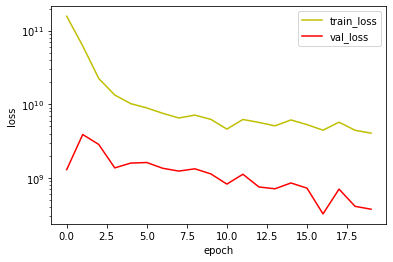

In [17]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(history.history['loss'], 'y', label='train_loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val_loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

plt.yscale("log")

loss_ax.legend()

plt.show()

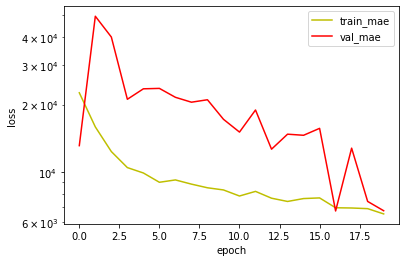

In [18]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(history.history['mae'], 'y', label='train_mae')
loss_ax.plot(history.history['val_mae'], 'r', label='val_mae')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

plt.yscale("log")

loss_ax.legend()

plt.show()

## 5. Clear models and Test

In [19]:
from model import remove_models
remove_models()

found best model: .\models\AcademyProject-epoch-017+val_loss-324090016.0000.hdf5
.\models\AcademyProject-epoch-001+val_loss-1295128448.0000.hdf5 removed.
.\models\AcademyProject-epoch-008+val_loss-1237901696.0000.hdf5 removed.
.\models\AcademyProject-epoch-010+val_loss-1133316352.0000.hdf5 removed.
.\models\AcademyProject-epoch-011+val_loss-823915072.0000.hdf5 removed.
.\models\AcademyProject-epoch-013+val_loss-752982848.0000.hdf5 removed.
.\models\AcademyProject-epoch-014+val_loss-711503744.0000.hdf5 removed.


In [20]:
model = get_model(input_shape=input_shape)

found best model: .\models\AcademyProject-epoch-017+val_loss-324090016.0000.hdf5


157/157 [==============================] - 2s 10ms/step


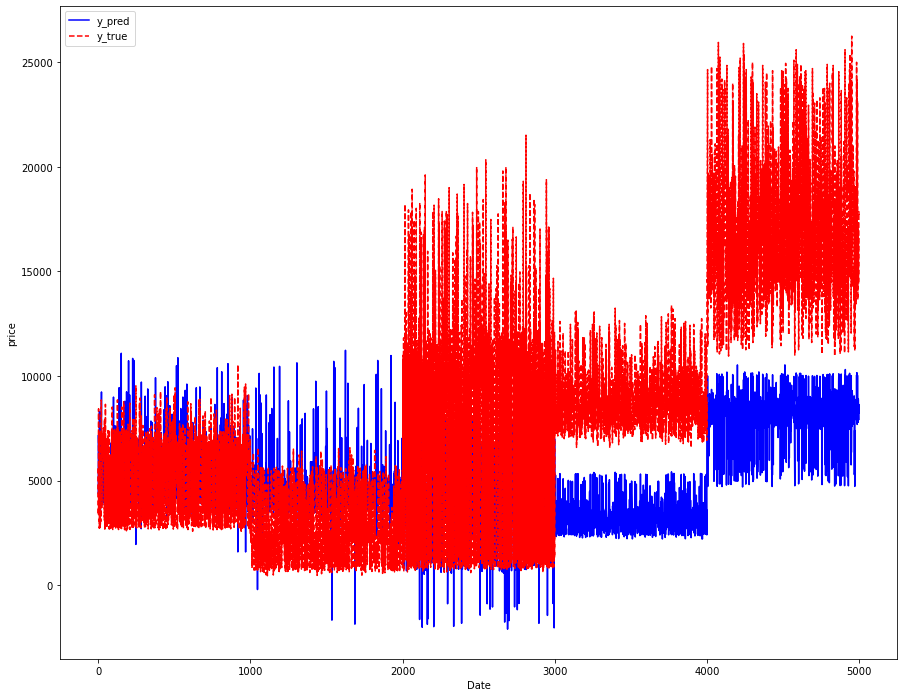

In [21]:
import matplotlib.pyplot as plt

arange = np.arange(5000, 10000)
y_pred = model.predict(x_raw_data[arange])
y_true = y_raw_data[arange]

plt.figure(figsize=(15, 12))

plt.plot(y_pred, 'b', label='y_pred')
plt.plot(y_true, '--r', label='y_true')

plt.xlabel('Date')
plt.ylabel('price')

plt.legend()
# plt.imsave('deeplearning_sample_dataset.png')

plt.show()